In [1]:
!pip install utm
!pip install geojsoncontour

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6108 sha256=ef2b3e72fffe7f8b43456ae10390276af15e3806e0c12b43df513e38444b8bde
  Stored in directory: /root/.cache/pip/wheels/65/e2/d8/878a8cc986641056fbfebefc4d8eb64238a7b6d3426e86b447
Successfully built utm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import utm
import geojsoncontour
from matplotlib.patches import Circle

In [3]:
# Define conversion functions
def utm_to_latlon(x, y):
    # Convert lat/lon to UTM coordinates
    lat, lon = utm.to_latlon(x, y, 32, 'U')

    return lat, lon

# Define conversion functions
def latlon_to_utm(lat, lon):
    # Convert lat/lon to UTM coordinates
    utm_x, utm_y, _, _ = utm.from_latlon(lat, lon)

    return utm_x, utm_y

In [4]:
# functions to look up min height from arrays

def find_closest_index(x_array, x):
    # Find the index of the closest value to x
    closest_index = np.argmin(np.abs(x_array - x))
    
    return closest_index

def find_min_hgt(lat, lon):

  x, y = latlon_to_utm(lat, lon)

  idx_x = find_closest_index(x_array, x)
  idx_y = find_closest_index(y_array, y)

  min_hgt = z_array_ft[idx_y][idx_x]

  return min_hgt

In [5]:
with open('x_results.pkl','rb') as f:
    x_results = pickle.load(f)

with open('y_results.pkl','rb') as f:
    y_results = pickle.load(f)

with open('z_results.pkl','rb') as f:
    z_results = pickle.load(f)

In [6]:
lst = z_results[0][0]

row=len(lst)
column=len(lst[0])
print(f'Rows:{row}, Column:{column}')

Rows:100, Column:100


In [7]:
x_array = np.array([])

for i in range(len(x_results)):
  x_array = np.concatenate((x_array, x_results[i][0]))

y_array = np.array([])

for j in range(len(y_results)):
  y_array = np.concatenate((y_array, y_results[0][j]))

In [8]:
lst = z_results

row=len(lst)
col=len(lst[0])

for j in range(0, row):
  #print('j=%s'%(j))
  for i in range(0, col):
    #print('i=%s'%(i))
    #print(z_results[i][j].shape)
    if i==0:
      z_array_row = z_results[i][j]
    else:
      z_array_row = np.hstack((z_array_row, z_results[i][j]))
  
  if j==0:
    z_array = z_array_row
  else:
    z_array = np.vstack((z_array, z_array_row))

In [9]:
z_array_ft = z_array / 0.3048 + 1000

In [12]:
# Open obstacle database
#
path_to_obstacles_json = './obstacles_ENR5.4.json'
with open(path_to_obstacles_json) as obstacles_database:
    obstacles_data = json.load(obstacles_database)
obs_df = pd.json_normalize(obstacles_data, record_path =['obstacles'])

obs_df = obs_df.drop(index=16)

In [13]:
obs_df

,id,name,permanent,lat,lon,height_m,terrain_elevation_m,ENR5.4
0,0,Colonius Fernsehturm,True,50.946944,6.931944,268,48,NORDRHEIN-WESTFALEN 204-10
1,1,Koelnturm (Mediapark),True,50.947908,6.942575,165,50,NORDRHEIN-WESTFALEN 271-10
2,2,Koelner Dom,True,50.941520,6.957296,157,55,NORDRHEIN-WESTFALEN 92-10
3,3,AREO Turm,True,50.911700,6.963006,76,51,NaN
4,4,Colonia Haus,True,50.960556,6.981667,148,46,NORDRHEIN-WESTFALEN 632-10
5,5,Koeln Triangle,True,50.940306,6.971778,106,45,NORDRHEIN-WESTFALEN 645-10
6,6,Uni-Center,True,50.921800,6.932576,133,52,NORDRHEIN-WESTFALEN 167-10
7,7,Krohstr. 4 (Bayenthal),True,50.907423,6.972111,73,52,NaN
8,8,TUV-Rheinland-Turm,True,50.924352,6.992429,114,50,NaN
9,9,Pollonius,True,50.921617,7.004475,115,45,NORDRHEIN-WESTFALEN 263-10


In [14]:
obs_df = obs_df.drop(index=9)

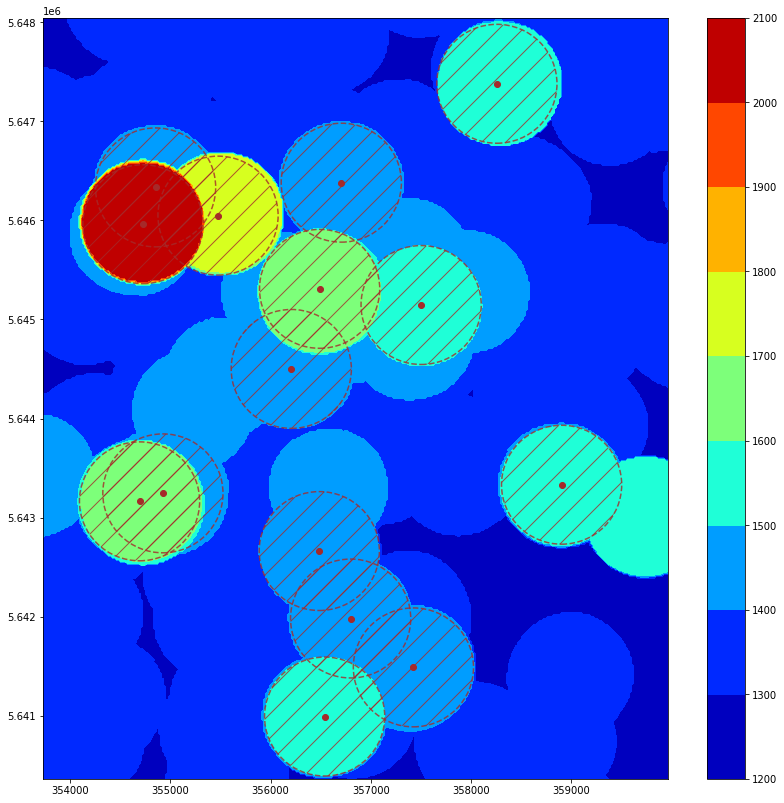

In [17]:
fig = plt.figure(figsize =(14, 14))
plt.contourf(x_array, y_array, z_array_ft, cmap = 'jet', levels=np.arange(1200,2200,100)) # levels=np.arange(60,340,10)

for idx, row_obs in obs_df.iterrows():
  x, y = latlon_to_utm(row_obs.lat, row_obs.lon)[0], latlon_to_utm(row_obs.lat, row_obs.lon)[1]
  circle_obs = Circle(xy=(x, y),radius = 600, fill=False, color='brown', linewidth = 1.5, linestyle='--', hatch='/', alpha = 0.8)
  plt.gca().add_patch(circle_obs)
  plt.plot(x, y,'o', color='brown', zorder = 10)
 
plt.colorbar()
plt.show()

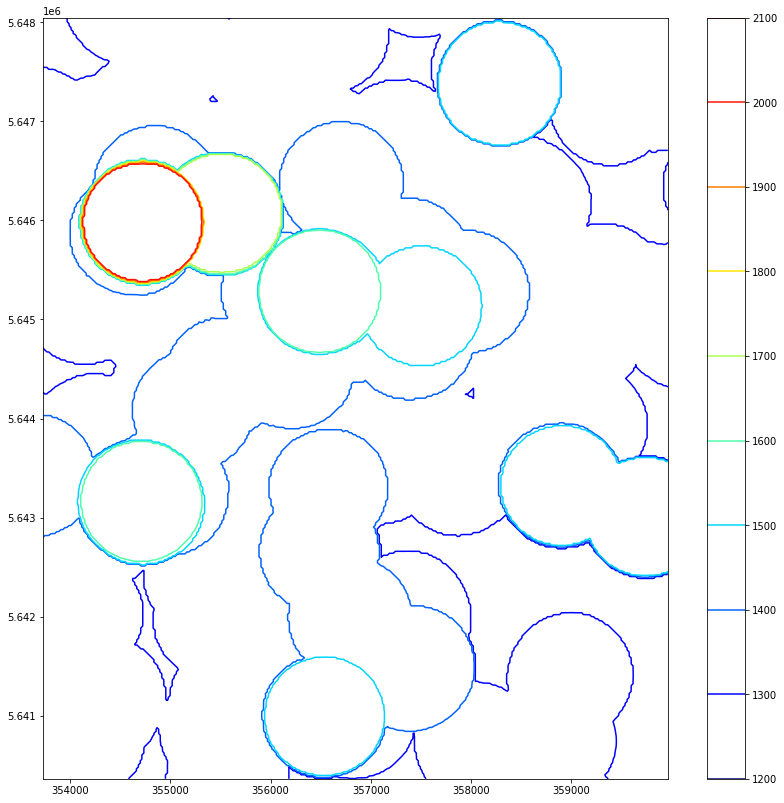

In [18]:
fig = plt.figure(figsize =(14, 14))
plt.contour(x_array, y_array, z_array_ft, cmap = 'jet', levels=np.arange(1200,2200,100))
 
plt.colorbar()
plt.show()

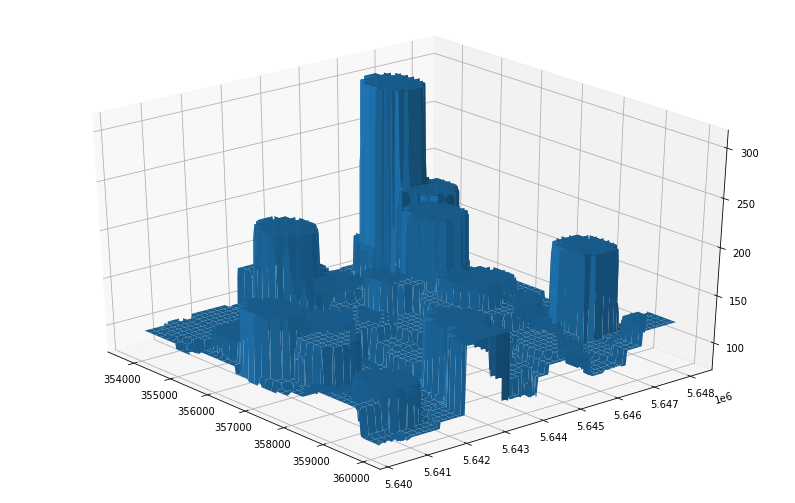

In [22]:
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

xx, yy = np.meshgrid(x_array, y_array)

# Creating plot
ax.plot_surface(xx, yy, z_array)

ax.view_init(30, -40)

# show plot
plt.show()

In [23]:
import plotly.graph_objects as go

fig = go.Figure(data =
    go.Contour(
        z=z_array_ft,
        x=x_array, # horizontal axis
        y=y_array # vertical axis
    ))

fig.update_layout(
    autosize=False,
    width=1000,
    height=1100,)

fig.show()

Finding minimum hgt from lat, lon

In [ ]:
find_min_hgt(50.943774, 6.962340)

1696.719160104987